# Dynamic Time Warping for Sequence-to-Sequence mapping of vector data

##  Use 5b. instead of this 5a. for more vector features


**Dates:**  
31/10/2023: v0.8.0 on win11   
10/01/2025: v0.8.3

### Modifications
31/10/2023:  use single quotes for formatting text in mpl.ax.text() to avoid FutureWarning


### DP Formulas

This DTW will find the alignment {(X_i(s),Y_j(s)), s=1:N} that minimizes:   
>    Sum_s \[ m_t \*||X_i(s)- Y_j(s)||^p + a_t \]  

with constraints   
>    i(1)=j(1)=1  ,  i(N)=Nx,j(N)=Ny   i(s)>=i(s-1),j(s)>=j(s-1),   
>    further subject to transition constraints (s-1)=>(s) and m_t and a_t transition costs

#### Data Structures

Feature Sequences are represented as

X(Nx,D), Y(Ny,D), ...  i.e. numpy arrays of size (number of frames, number of features)   

A 1D array of length N is cast to a a 2D array of size (N,1)
Therefore a single feature of width D must be explicitly passed as a (1,D) 2D array

In [1]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import math

import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Box, HBox, VBox, Layout,interactive
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.dtw as dtw

    
# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\compi\AppData\Local\Temp\ipykernel_8368\413698579.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Example 1:  1D feature vectors
- first define two some sequences   
    The feature vectors are scalars (1D vectors) 
- run a standard DTW algorithm on it and print a trellis   
    The local distance metric applied is 'Euclidean Squared' and use the Levenshtein algorithm for aligning, i.e.
    we can move diagonal, horizontal or vertical (always in the direction of time)

In [2]:
x1d = np.array([.05, -.1, 0.77, .335, .95, 1.75])
y1d = np.array([0.,1.,2.])
# we also define some plotting arguments for this example
plt_args = {'xy_annot':True,'ftr_annot':True,'fig_width':5,'ftr_scale':.15,'fmt':"{:.3f}",'text_size':"xx-small"}

DTW distance: 3.067 


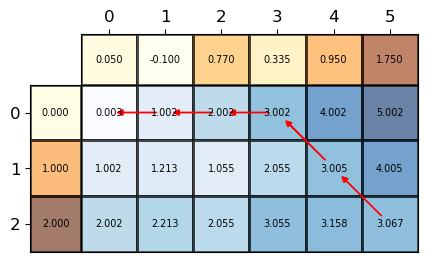

In [3]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x1d,y1d,trans='LEV',result='details')
print("DTW distance: %.3f " % dist)

dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,**plt_args)

## Steps in the DTW algorithm
1. Local Distance Computation
Compute for each pair (x_i, y_j) a distance.  This feature by feature distance, organized in a matrix is called the "local distance matrix"
2. Trellis Computation
In a trellis we compute accumulated distances.  Each cell contains a sum of local distances , starting up to the current cell.
Thus cell (Nx,Ny) contains the full sequence distance.   
Obviously the computation of cummulative distance this is subject to the allowed transitions.  
To maintain the memory of how we moved from one cell to another
we add backpointers in each cell
3. Backtracking
In order to find the alignment between the two sequences. We follow backpointers from the end back to the start

### Trellis Representation
The trellis is a matrix arrangement in which each cell (i,j) says something about the relationship between x\[i\] and y\[j\] or up to that moment in time for both sequences.   
We tend to add extra space in the plot for the feature vectors, typically clearly visable by the different colormaps.

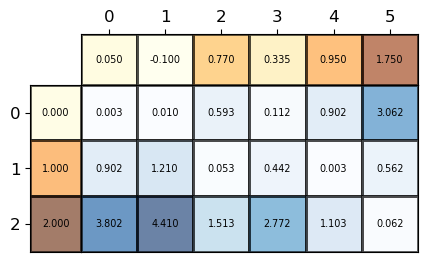

In [4]:
#STEP1: Compute the local distance matrix
fig1 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=ld_matrix,**plt_args)
fig1

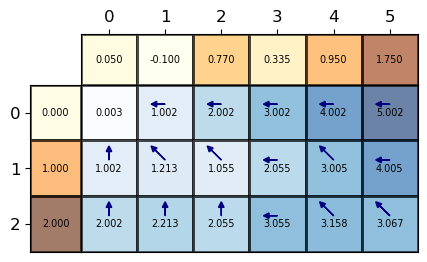

In [5]:
# STEP2: Compute the Cummulative Distance Matrix and add backpointers
fig2 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,bptrs=bptrs,**plt_args)
fig2

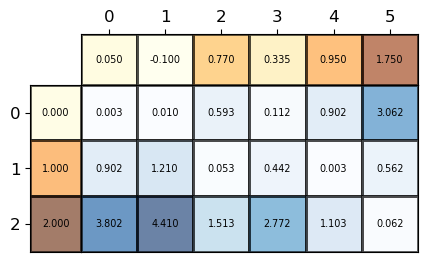

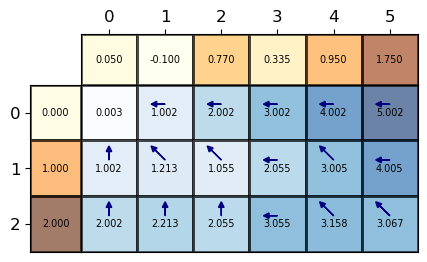

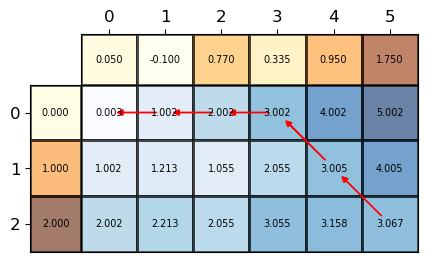

In [6]:
# STEP 3: Follow the backpointers in reverse order from end to beginning to find the optimal alignment
#xy_annot=True,ftr_annot=True,fig_width=4,fmt="{:.3f}",text_size="x-small"

fig3 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig1,fig2,fig3)

In [7]:
x_wp,y_wp = dtw.warp(x1d,y1d,trace)
pd.DataFrame((x_wp,y_wp))

,0,1,2,3,4,5
0,0.05,-0.1,0.77,0.335,0.95,1.75
1,0.00,0.0,0.00,0.000,1.00,2.00


In [8]:
# We can simply show the aligned versions of both sequences as well
dtw.align(x1d,y1d,trace).T

,0,1,2,3,4,5
x,0.05,-0.1,0.77,0.335,0.95,1.75
y,0.00,0.0,0.00,0.000,1.00,2.00


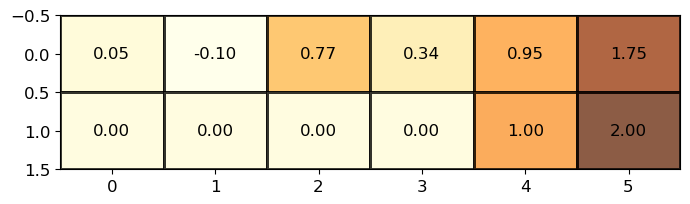

In [9]:
f,ax=plt.subplots(figsize=(8,2))
ax.invert_yaxis()
dtw.text_heatmap(np.array([x_wp,y_wp]),ax=ax,annot=True,edgecolor='k',cmap='YlOrBr',alpha=.75)

In [10]:
def plot2(x=None,y=None,trace=None,dist=None,down_sample=1,figsize=(10,4),cmap='YlOrBr',alpha=0.7):
    '''
    plots linear alignment
    '''
    if x.ndim == 1 : x=x.reshape(-1,1)
    if y.ndim == 1 : y=y.reshape(-1,1)
    xrange = [-.5,max(x.shape[0],y.shape[0])-.5]
    fig = Spd.SpchFig(row_heights=[2. , 1., 2.], figsize=figsize )
    
    fig.add_img_plot(y.T,iax=0,cmap=cmap,alpha=alpha)

    fig.add_img_plot(x.T,iax=2,cmap=cmap,alpha=alpha)
    for ax in fig.axes:
        ax.set_xlim(xrange)
        ax.axis('off')
    for i in range(len(y)):
        fig.axes[0].text(i,0,y[i])
    for i in range(len(x)):
        fig.axes[2].text(i,0,x[i])        
        
    fig.axes[1].set_ylim([-1.,1.])
    ax = fig.axes[1]

    if trace is None:
        if len(x) == len(y):
            trace = []
            for i in range(len(y)): trace.append([i,i])
            
    if trace is not None:

        for i in range(0,len(trace),down_sample) :
            ax.plot(trace[i],[-1,1],linestyle='dashed',color='k')        
        if dist is not None:
            for i in range(0,len(trace),down_sample) :
                ax.text((trace[i][0]+trace[i][1])/2.,0,'{:.2f}'.format(dist[i]))
                #ax.text(trace[i],[-1,1],linestyle='dashed',color='k'
    return(fig)

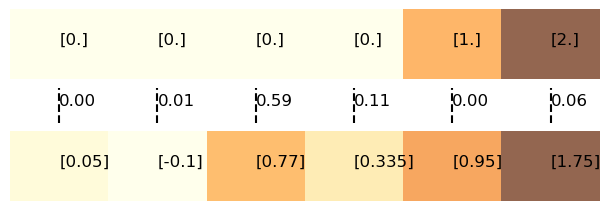

In [11]:
plot2(x_wp,y_wp,None,np.square(x_wp-y_wp),figsize=(6,2))

### Use of subfigures to get side by side displaying

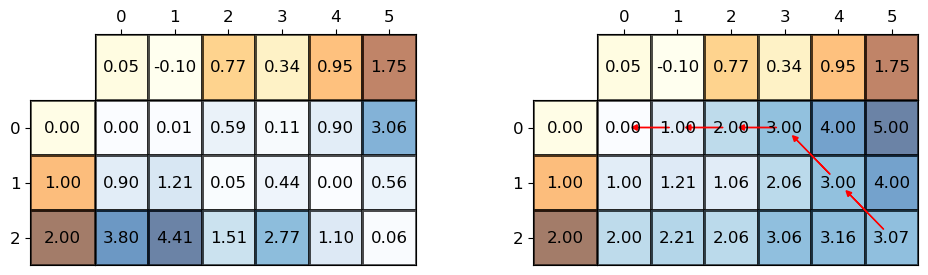

In [12]:
fig = plt.figure( figsize=(10, 3))
subfigs = fig.subfigures(1, 2, wspace=.01)
# plotting local distance matrix and both x- and y-features
dtw.plot_trellis(fig=subfigs[0],x=x1d,y=y1d,xy_mat=ld_matrix,xy_annot=True,ftr_annot=True)
dtw.plot_trellis(fig=subfigs[1],x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,xy_annot=True,ftr_annot=True)
display(fig)

## Example with Strings and Characters

Levenshtein distance was originally developed for character string matching in which 3 basic operations were
defined: Subsititution, Insertion, Deletion.  There was no concept of 'local distances', only of costs related to the different type of operations.

For equal penalties, the Levenhstein distance computation is equally well implemented with the DTW algorithm
and the local distance concept where non matching entries get a cost
and matching entries a zero cost.  That combined with the Levenshtein moves leads to a Levenshtein matching.




In [13]:
#
# Define a few utility functions that deal with character match/mismatch
#
def letter_class(a):
    if a.lower() in 'aeiou' : return('VOWEL')
    elif a.lower() in 'pbtdkg' : return('PLOSIVE')
    elif a.lower() in 'mnlr' : return('LIQUID')
    elif a.lower() in 'sfzvc' : return('FRICATIVE')
    else: return(None)
    
def letter_sym(a,b):
    '''
    a very ad hoc sound similarity measure between letters
    returns
        0: a == b
        1: class(a) == class(b)  for defined classes 
        2: otherwise
    '''
    _DIFFERENT = 1.
    _SIMILAR = .6
    _SAME = 0
    
    if a == b: return(_SAME)
    class_a = letter_class(a)
    class_b = letter_class(b)
    if class_a is None or class_b is None: return(_DIFFERENT)
    if class_a == class_b: return(_SIMILAR)
    else: return(_DIFFERENT)

def letter_sym_matrix(x,y):
    '''
    constructs sound similarity matrix for arrays x and y
    '''
    x = x.flatten()
    y = y.flatten()
    Nx = len(x)
    Ny = len(y)
    dist_matrix = np.zeros((Nx,Ny),dtype='float32')
    for i in range(Nx):
        for j in range(Ny):
            dist_matrix[i,j] = letter_sym(x[i],y[j])
    return(dist_matrix)

def ld_rand(x,y):
    Nx = len(x)
    Ny = len(y)
    dist_matrix = np.random.rand(Nx,Ny) 
    return(dist_matrix)

In [14]:
# Add a dummy symbol at beginning if you want to allow for initial insertions/deletions
syms = ['nebukadnezar','nabukodonosor']
syms = ['volodomir','vladimirski']
syms= ['recognize speech','wreck a nice beach']
syms = ['in the skies','in disguise']
#syms = ['albert einstein','max levenshtein']
#syms = ['law and order','laura norder']
syms = ['this evening','deceiving']
#
x_str = np.array(list(syms[0]))
y_str = np.array(list(syms[1]))  
plt_args = {'xy_annot':True,'ftr_annot':True,'fig_width':8,'ftr_scale':.07,'text_size':'small','ftr_args':{'alpha':.2}}

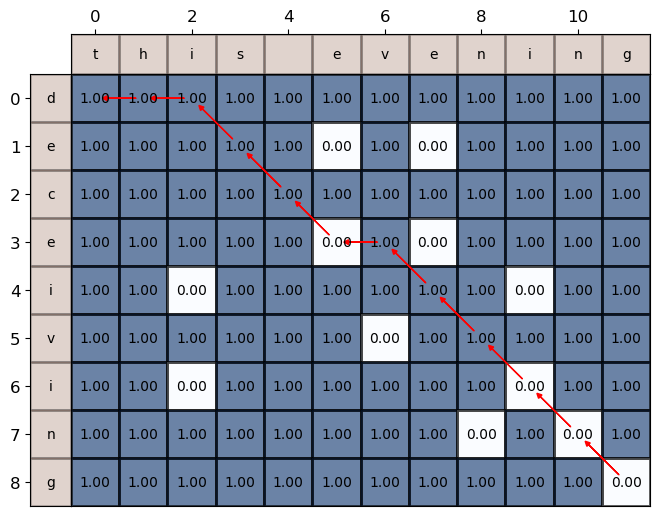

DTW distance =  8.0


,0,1,2,3,4,5,6,7,8,9,10,11
x,t,h,i,s,,e,v,e,n,i,n,g
y,d,_,_,e,c,e,_,i,v,i,n,g
E,S,I,I,S,S,H,I,S,S,H,H,H


In [15]:
# Levensthein distance allows for  INS/SUB/DEL
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_str,y_str,trans='LEV',
                                               result='details',p="hamming")
fig = dtw.plot_trellis(x=x_str,y=y_str,xy_mat=ld_matrix,trace=trace,**plt_args)

display(fig)
print("DTW distance = ",dist)
display(dtw.align(x_str,y_str,trace,EPS='_').T)

## Character mismatch costs
Character specific mismatch costs are easily added to the concept when using the DTW algorithm to implement Levenshtein style sequence matching.  In the example below we pass our very ad hoc 'letter_sym_matrix' similarity function which gives smaller penalties when
vowels match vowels, plosives match plosives, ..

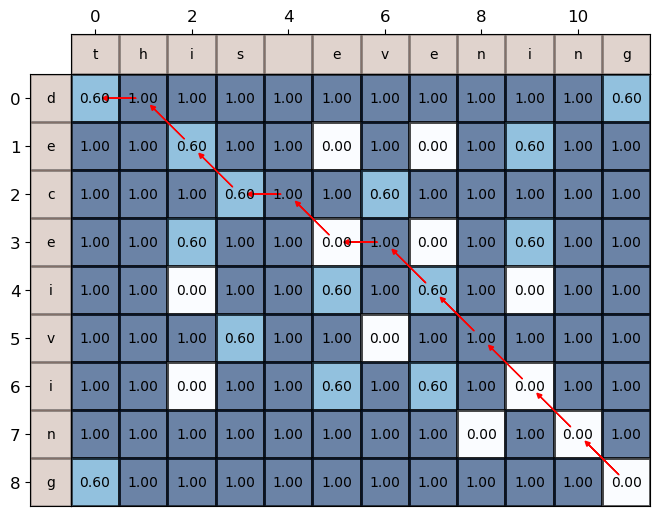

DTW distance =  6.400000095367432


,0,1,2,3,4,5,6,7,8,9,10,11
x,t,h,i,s,,e,v,e,n,i,n,g
y,d,_,e,c,_,e,_,i,v,i,n,g
E,S,I,S,S,I,H,I,S,S,H,H,H


In [16]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_str,y_str,trans='LEV', ld_func=letter_sym_matrix,
                                               result='details',p="hamming")
fig = dtw.plot_trellis(x=x_str,y=y_str,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)
display(dtw.align(x_str,y_str,trace,EPS='_').T)

## Multi-dimensional Features
In this exampe we pass 2D feature vectors

In [17]:
#x2d = np.array([[0.,1.,2.,1.,0.,0.1,-0.1,0.,.05],[0.3,1.3,1.5,1.5,1.,0.3,-0.24,0.3,.05]]).T
x2d = np.array([[0.,1.,2.,1.,0.,0.1,.05],[0.3,1.3,1.5,1.5,1.,0.3,.05]]).T
y2d = np.array([[0.,0.,0.,1.,2],[1.,1.,1.,1.,-1]]).T + .1*np.random.rand(5,2)
plt_args = {'xy_annot':True,'ftr_annot':True,            
            'xy_args':{'alpha':.2,'edgecolor':'k'}, 
            'bptr_args':{'color':'orange','linewidth':3},
            'ftr_args':{'cmap':'YlOrBr','edgecolor':'g','alpha':.3}
            }

x_ftrs=x2d
y_ftrs=y2d

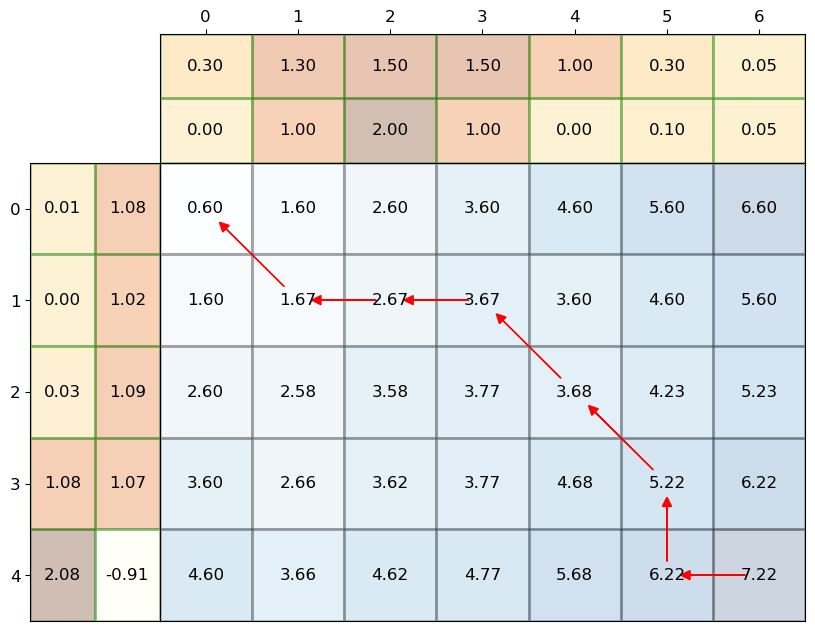

DTW distance =  7.217239071925628


In [18]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='LEV',result='details',CLIP=True)
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)

## ITAKURA constraints
Long verticle or horizontal segments in the alignment are indications of true mismatch at those locations.
Good alignments typical are close to the diagonal or at least have mostly diagonal fragments.

For speech in particular speaking rate differences tend to be limited.
Hence popular in the speech community are the so called ITAKURA onstraints in sequence matching.   
Itakura allows single jump in x or y direction while the other index just increases by 1 .  
In the dtw.dtw() implementation we penalize the jump moves by 20% vs. regular diagonal moves, to account for this less than optimal alignment.       
This allows for a speedup of x2 on either axis    
ITAKURA and LEVENSHTEIN are SYMMETRIC 
In the plot below we show the cummulative distance matrix.  
The high values in lower left and upper right corners basically indicate regions that are not reachable with
ITAKURA constraints starting from the origin.


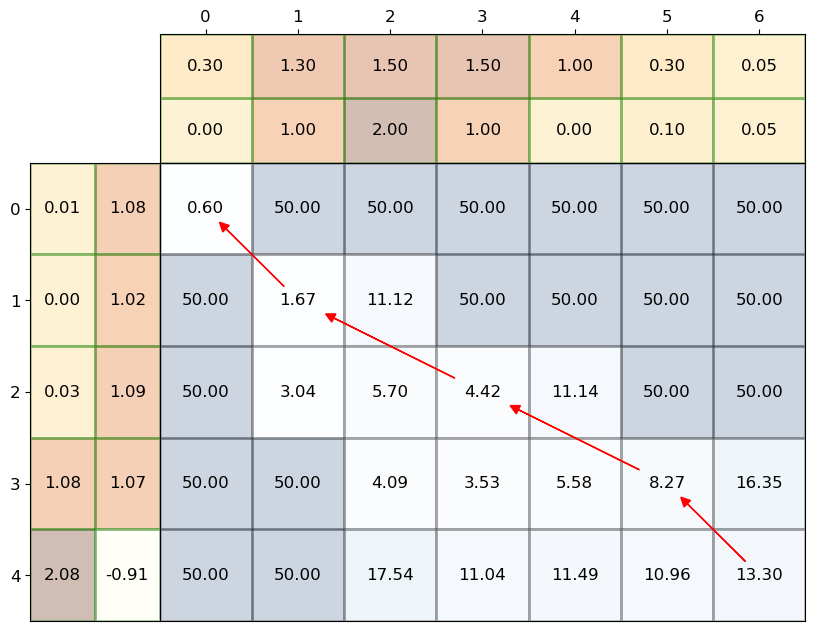

DTW distance =  13.299036404470016


In [19]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='ITA',result='details',CLIP=True)
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)

# Now with speech data

In [20]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/audio/'
# sa1: she had your dark suit in greasy washwater all year
# sa2: don't ask me to carry an oily rag like that
# note there are some word segmentation errors in sa1, phn segmentations are OK

yname = dir+'train/dr1/fcjf0/sa2'
xname = dir+'train/dr1/fdaw0/sa2'

xwavdata, sr = Spch.load(xname+".wav")
ywavdata, sr = Spch.load(yname+".wav")

xsegdata = Spch.read_seg_file(xname+ ".wrd",dt=1/sr,fmt='float32')
ysegdata = Spch.read_seg_file(yname+ ".wrd",dt=1/sr,fmt='float32')
# compute a spectrogram with default parameters

n_mels = None
shift=0.01
length=0.03
n_shift = int(shift*sr)
n_length = int(length*sr)
#
xspgdata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,n_mels=None)
xmeldata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,n_mels=24)
(nparam,xnfr)=xspgdata.shape
d_freq = sr/(2.*(nparam-1))
yspgdata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,n_mels=None)
ymeldata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,n_mels=24)

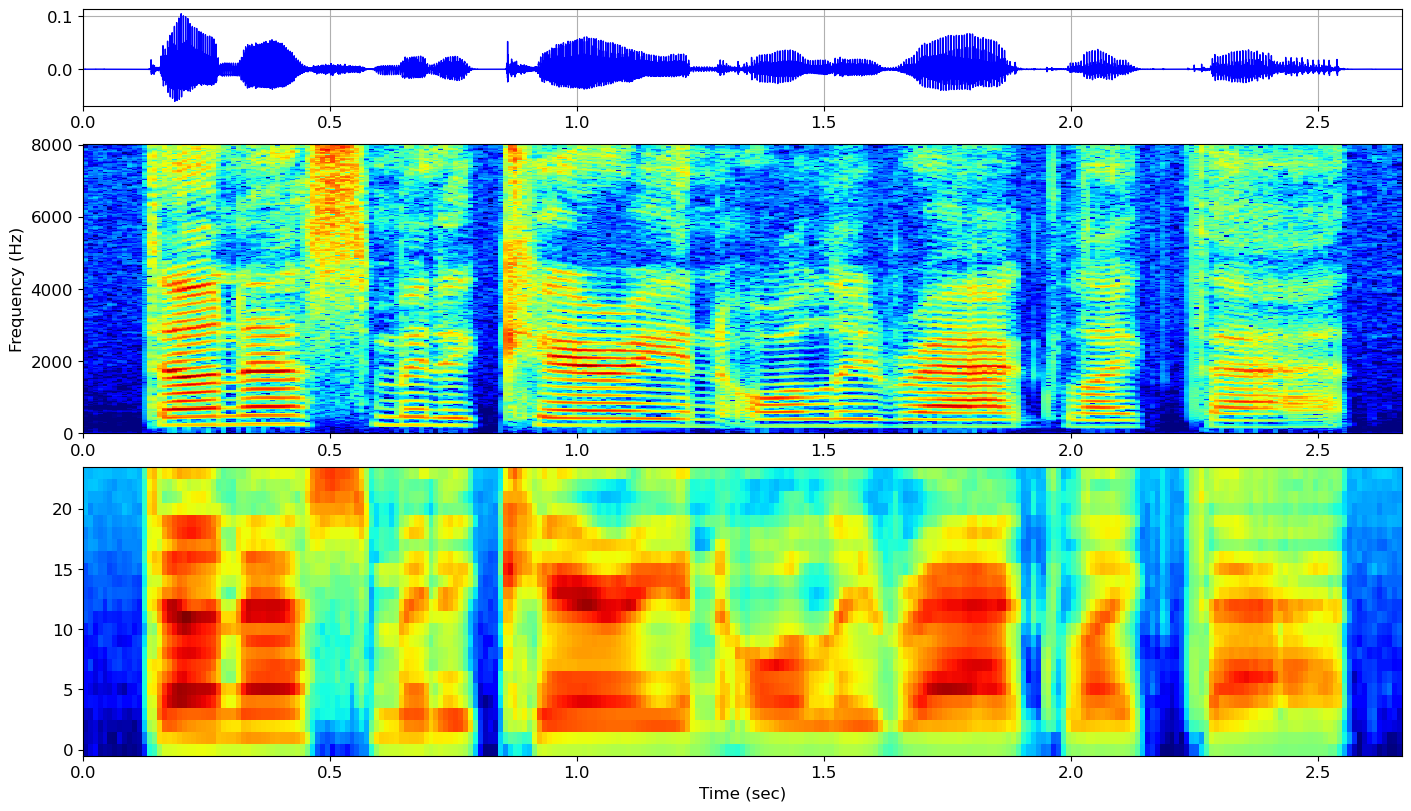

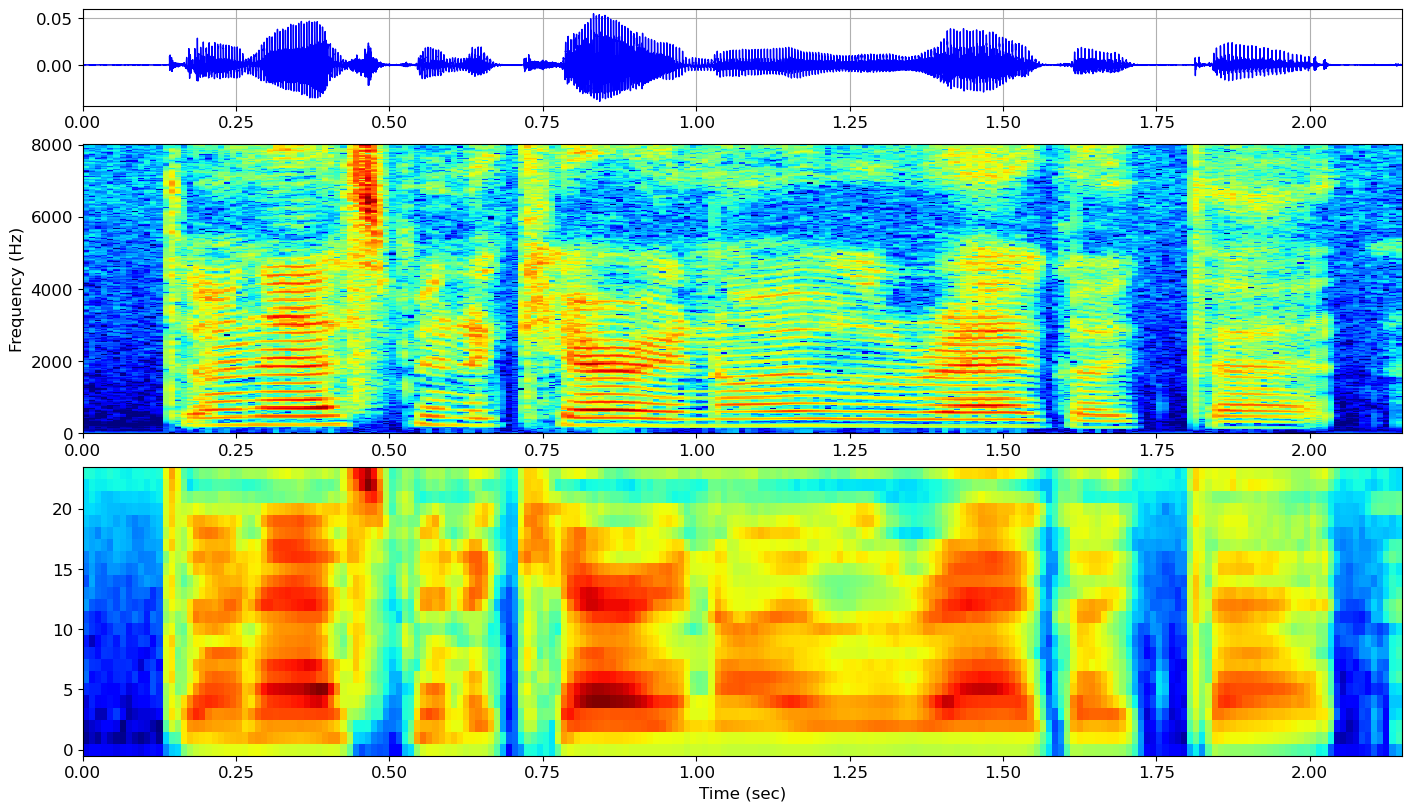

In [21]:
# just displaying the spectrograms and mel spectrograms of both sentences
fig = Spd.PlotSpgFtrs(wavdata=xwavdata,spgdata=xspgdata,#segwav=xsegdata,
                      img_ftrs=[xmeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)
#
fig = Spd.PlotSpgFtrs(wavdata=ywavdata,spgdata=yspgdata, #segwav=ysegdata,
                  img_ftrs=[ymeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)

## pc

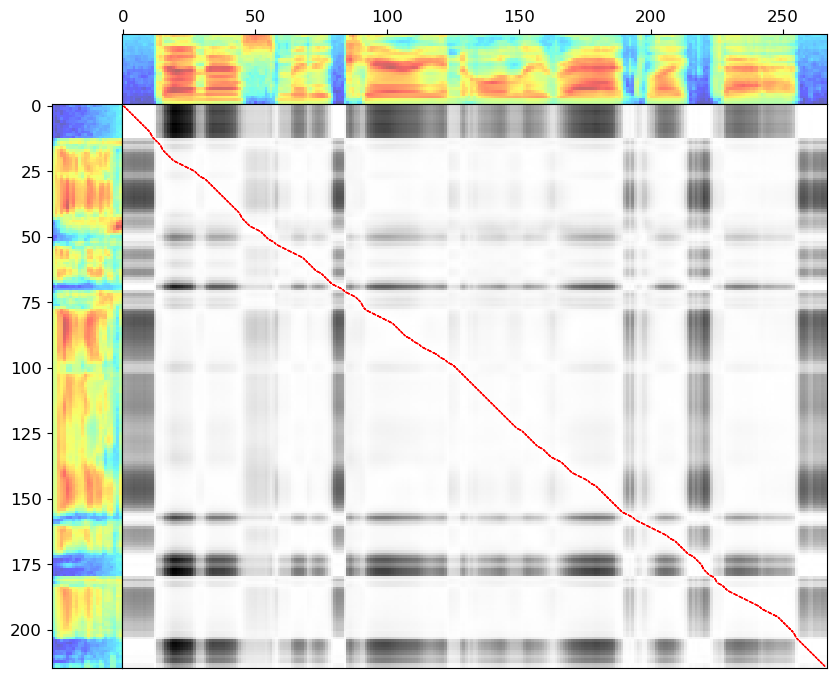

In [47]:
plt_args = {'fig_width':10,'ftr_scale':.1,'ftr_args':{'cmap':'jet','edgecolor':None},
            'xy_args':{'cmap':'Greys','alpha':1} }
x_ftrs = xmeldata.T
y_ftrs = ymeldata.T
#x_ftrs = xspgdata.T
#y_ftrs = yspgdata.T

cost,trace,ld_matrix,cd_matrix,_ = dtw.dtw(x_ftrs,y_ftrs,trans='ITA',result='details')
fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=y_ftrs,x=x_ftrs,**plt_args)
#fig = dtw.plot_trellis(xy_mat=ld_matrix,x=x_ftrs,y=y_ftrs)
#fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=yspgdata[0:255,:].T,x=xspgdata[0:255,:].T,**plt_args)
fig

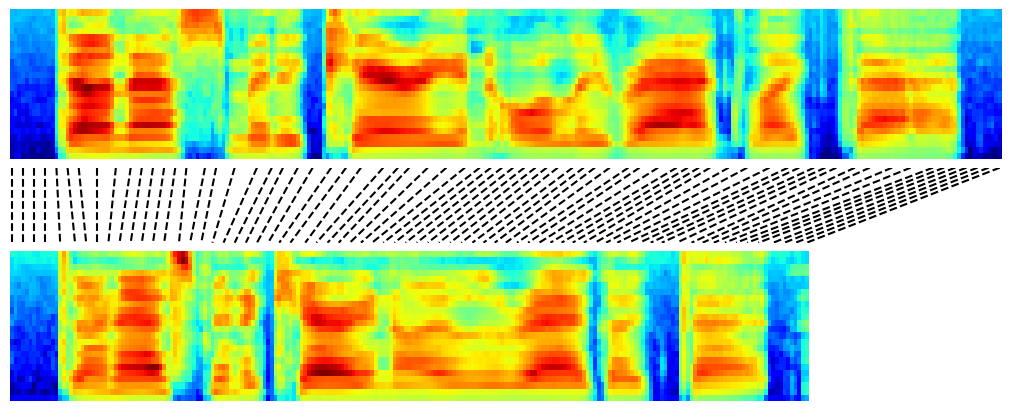

In [48]:
dtw.plot_align(x_ftrs,y_ftrs,trace,cmap='jet',down_sample=3)

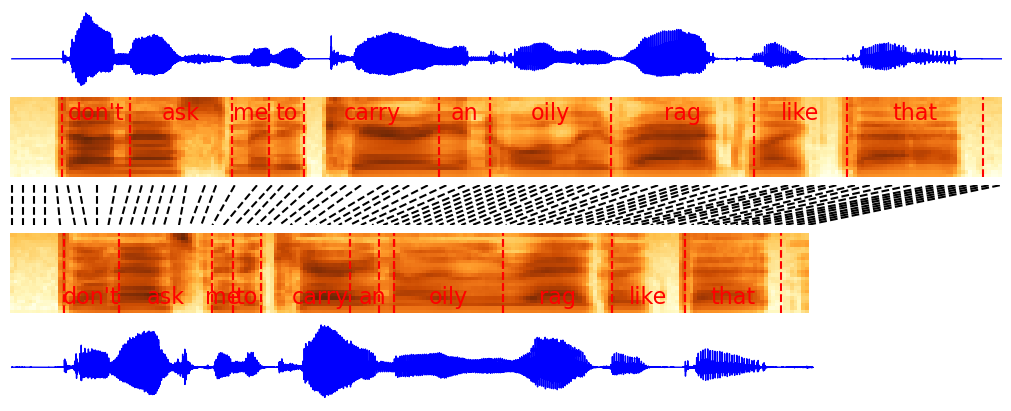

In [49]:
fig = dtw.plot_align(x_ftrs,y_ftrs,x_wav=xwavdata,y_wav=ywavdata,x_seg=xsegdata,y_seg=ysegdata,trace=trace,shift=shift,sr=sr,down_sample=3)
fig